# Hackathon #2

Topics: 
- Linear and Non-Linear Transformations
- Gradient Descent Optimization
- Training by minibatch/gradient step and epoch
- TensorBoard

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# we'll start with our library imports...
# tensorflow to specify and run computation graphs
# numpy to run any numerical operations that need to take place outside of the TF graph
import tensorflow as tf
import numpy as np
# this one lets us draw plots in our notebook
import matplotlib.pyplot as plt

### A First Attempt at Classifying MNIST

Let's have a look at our data first. We'll use the `next_batch` function to get subsets of the data in parallel arrays, which returns a tuple of images and labels. The images (shape `[28,28]`) are initially flat when we get them (shape `[784]`), but we can use [np.reshape](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.reshape.html) to correct that and allow us to plot the image with `matplotlib`. The labels are "one-hot", or arrays of length 10 (the number of classes) with a single index set to 1 and the rest to 0, indicating the integer value.

MNIST is a dataset of handwritten digits, and we'll use it for a 10-class classification problem.

Train image tensor shape: (55000, 784)
Train label tensor shape: (55000, 10)
Test image tensor shape: (10000, 784)
Test label tensor shape: (10000, 10)
A label looks like this: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
And an image looks like this:


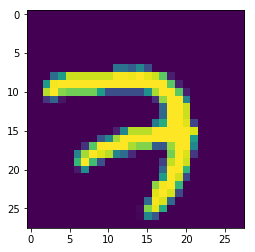

In [2]:
# extract our dataset, MNIST
dir_prefix = '/work/cse496dl/shared/hackathon/02/mnist/'
train_images = np.load(dir_prefix + 'mnist_train_images.npy')
print("Train image tensor shape: " + str(train_images.shape))
train_labels = np.load(dir_prefix + 'mnist_train_labels.npy')
print("Train label tensor shape: " + str(train_labels.shape))
test_images = np.load(dir_prefix + 'mnist_test_images.npy')
print("Test image tensor shape: " + str(test_images.shape))
test_labels = np.load(dir_prefix + 'mnist_test_labels.npy')
print("Test label tensor shape: " + str(test_labels.shape))
# visualize some of the data
print("A label looks like this: " + str(train_labels[0]))
print("And an image looks like this:")
imgplot = plt.imshow(train_images[0].reshape((28,28)))

We'll start specifying a simple neural network in this hackathon. The most basic building block is the linear transformation (AKA dense layer, linear layer, or fully connected layer), so we'll declare a function that creates the layer. Each is composed of two variables, the weight matrix and the bias vector, to calculate the function `f(x) = a(Wx + b)` where `a` is the activation function.

In [3]:
def linear_layer(x, output_size, activation=tf.identity, name='linear'):
    """
    Args:
        - x: a rank two tensor, [batch_size, data_size]
        - output_size: (int) number of neurons
        - activation: function applied to the output
        - name: TensorFlow name scope for variable
    """
    with tf.name_scope(name) as scope:
        (_, data_size) = x.get_shape().as_list()
        W = tf.Variable(tf.truncated_normal([data_size, output_size]), name='weights')
        b = tf.Variable(tf.truncated_normal([output_size]), name='bias')
        return activation(tf.matmul(x, W) + b)

The first dimension of the input is usually reserved to be the "batch" dimension, which allows us to run many data through the model simultaneously. Then, each column of `W` corresponds to the weights of one linear unit of the layer. After adding the bias vector, we activate with a non-linearity or the identity, if we just want to use a linear transformation. [tf.name_scope](https://www.tensorflow.org/api_docs/python/tf/name_scope) is used to group the laher parameters, and its effects can be seen in TensorBoard.

TensorFlow variables, which host the model parameters persistently in the graph, are declared with [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable), needing only an initial value to be created. You can also name the variable or set it to be untrainable, but both are optional and `Variable`s are trainable by default. We use [tf.truncated_normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) to provide our initial values here, but there are much better initialization schemes (just make sure you never use a constant, e.g., [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)).

Then, we'll define a simple, two layer network with this function. We activate its output with [tf.nn.softmax](https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/softmax) so that we can interpret its output as the parameters of a discrete probability distribution.

In [4]:
x = tf.placeholder(tf.float32, [None, 784], name='data')
# use a single name scope for the model
with tf.name_scope('linear_model') as scope:
    hidden = linear_layer(x, 200, name='hidden_layer')
    output = linear_layer(hidden, 10, activation=tf.nn.softmax, name='output_layer')
tf.summary.FileWriter("logs", tf.get_default_graph()).close()

In the last line, we log what we just defined with TensorBoard for visualization. We use [tf.get_default_graph](https://www.tensorflow.org/api_docs/python/tf/get_default_graph) to retrieve a handle to the TF graph that we're working in (the default because we haven't specified a particular graph), and then we write a summary of the graph with [tf.summary.FileWriter](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter). This puts an events file in the "logs" directory which maybe opened with TensorBoard. Access by running `tensorboard --logdir=logs` and pointing a browser at http://localhost:6006. We can't do this on Crane, but you could download the log file and perform this process locally.

Note that, though the number of units in the hidden layer may be chosen freely as a hyperparameter, the number of units in the output unit must equal the number of classes in any classification problem.

To summarize how the model is performing in its classification task, let's add a placeholder for the correct output and calculate the [cross-entropy](https://stackoverflow.com/a/41990932) loss between the estimated and correct discrete distributions (i.e., between the model's softmaxed distribution and a distribution with a probability of 1 in the correct class, a one hot vector). We use `EPSILON` to avoid trying to calculate `log(0)` which is undefined.

In [5]:
y = tf.placeholder(tf.float32, [None, 10], name='label')
EPSILON = 1e-10
with tf.name_scope('cross_entropy') as scope:
    cross_entropy = -tf.reduce_sum(output * tf.log(y + EPSILON), axis=1)
tf.summary.FileWriter("logs", tf.get_default_graph()).close()

Now that we've constructed the TF graph, we'll create a session, initialize all variables, and run through an epoch of the test set to plot a histogram of the cross-entropy loss. (One epoch is an iteration of minibatches such that each datum is seen once. Minibatches are also frequently referred to as "batches", as below)

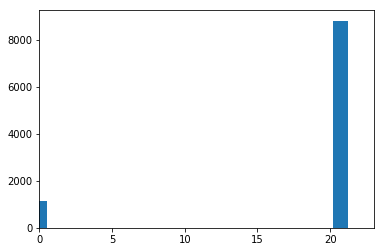

In [6]:
# calculate values of interest to minibatching and epoch calculation
# batch_size is adjustable
train_num_examples = train_images.shape[0]
test_num_examples = test_images.shape[0]
batch_size = 32

# finalize the graph
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    loss_vals = []
    # loop through each test datum once, saving the cross entropy
    for i in range(test_num_examples // batch_size):
        batch_xs = test_images[i*batch_size:(i+1)*batch_size, :]
        batch_ys = test_labels[i*batch_size:(i+1)*batch_size, :]
        ce_val = session.run(cross_entropy, {x: batch_xs, y: batch_ys})
        loss_vals.append(ce_val)
# now plot per-datum losses
loss_vals = np.concatenate(loss_vals)
hist, bin_edges = np.histogram(loss_vals)
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

It looks like the model guesses the correct class (corresponding to low loss and the smaller bar on the right) on about 10% of the data, which we would have anticipated for a naive model in a 10 class problem. We can improve this model. Let's try this again, with an optimizer and a non-linearity.

### A Second Attempt...


In [7]:
# Clear the graph so we can re-use it. If this is omitted, we get an error.
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784], name='data')
# use a single name scope for the model
with tf.name_scope('linear_model') as scope:
    hidden = tf.layers.dense(x, 200, activation=tf.nn.relu, name='hidden_layer')
    output = tf.layers.dense(hidden, 10, name='output_layer')

This time, we're using [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/layers/dense), which has a very similar API to our custom function, but much more functionality. Also, note that we're using [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu) as the activation of our hidden layer.

Further, instead of using a custom cross-entropy function, which lots of potential for numerical instability, we'll use TF's built in function, [tf.nn.softmax_cross_entropy_with_logit](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits). It combines the `softmax` activation of the final layer with the cross-entropy calculation.

In [8]:
# define classification loss
y = tf.placeholder(tf.float32, [None, 10], name='label')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output)

Now, using the loss tensor, we'll define an optimizer that uses backpropagation to update the values of each layer's variables.

In [9]:
# setup optimizer and training operation
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(cross_entropy)
tf.summary.FileWriter("logs", tf.get_default_graph()).close()

We'll use the [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#minimize) optimizer (usually a safe first choice), and use the [minimize](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#minimize) function which is defined for every TensorFlow optimizer. It returns an operation that automatically calculates the gradient of the provided function, and updates all variables marked trainable. We'll pass it to `sess.run` to train for one epoch and then check the test loss values again.

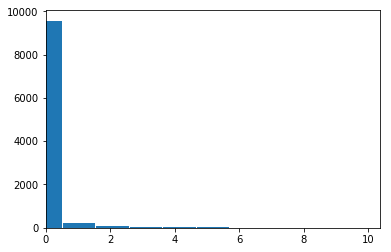

In [10]:
batch_size = 32
session = tf.Session()
session.run(tf.global_variables_initializer())

# train for one epoch
for i in range(train_num_examples // batch_size):
    batch_xs = train_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = train_labels[i*batch_size:(i+1)*batch_size, :]       
    session.run(train_op, {x: batch_xs, y: batch_ys})

# loop through each test datum once
loss_vals = []
for i in range(test_num_examples // batch_size):
    batch_xs = test_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = test_labels[i*batch_size:(i+1)*batch_size, :]
    ce_val, output_ndarray = session.run([cross_entropy, output], {x: batch_xs, y: batch_ys})
    loss_vals.append(ce_val)

# now plot per-datum losses
loss_vals = np.concatenate(loss_vals)
hist, bin_edges = np.histogram(loss_vals)
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

Just one training epoch has dramatically improved the model's performance. But on how many of the instances is it actually guessing the correct label?

## Hackathon 2 Exercise 1

Write code to calculate the maximum aposteriori (MAP) estimate of the model on the test data, and compare to the true labels to calculate a confusion matrix with [tf.confusion_matrix](https://www.tensorflow.org/api_docs/python/tf/confusion_matrix). (For the inexperienced, [what is a confusion matrix?](https://en.wikipedia.org/wiki/Confusion_matrix))

(Hint #0: Re-use and modify my code from above. Try not to reinvent the wheel, but always remember to cite borrowed code.)

(Hint #1: The MAP estimate is just the class whose probability is greatest. I reccomend using [tf.argmax](https://www.tensorflow.org/versions/master/api_docs/python/tf/argmax) with the correct `axis` argument to find this to find the max over the correct dimension of the output.)

(Hint #2: tf.confusion_matrix is a function that needs be run in a `session.run` call that returns matrices. Store the resulting matrices in a list and then sum to get the matrix for the full test dataset. Remember to specify the `num_classes` argument.)

In [11]:
# Your code here

In [13]:
# A solution
matrices = []
for i in range(test_num_examples // batch_size):
    batch_xs = test_images[i*batch_size:(i+1)*batch_size, :]
    batch_ys = test_labels[i*batch_size:(i+1)*batch_size, :]
    conf_matrix_op = tf.confusion_matrix(tf.argmax(y, axis=1), tf.argmax(output, axis=1), num_classes=10)
    conf_matrix = session.run(conf_matrix_op, {x: batch_xs, y: batch_ys})
    matrices.append(conf_matrix)
print(np.sum(matrices, axis=0))

[[ 970    0    1    1    1    3    1    1    1    0]
 [   0 1124    2    1    1    0    2    0    3    0]
 [   8    9  980    3    7    1    4    7   11    0]
 [   1    3   10  896    4   80    0    7    4    3]
 [   1    0    4    0  959    0    6    0    3    7]
 [   4    2    0    1    3  873    4    0    2    1]
 [  11    3    1    0    8   29  902    0    2    0]
 [   1   15   16    1    7    1    0  971    1   14]
 [   6    7    4    7   13   44    3    5  880    4]
 [   8    8    1    4   35   16    1    6    2  927]]


## Coda

### Saving and Loading TF models

https://www.tensorflow.org/programmers_guide/saved_model

### Numpy Broadcasting

TensorFlow uses [Numpy broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html) when doing arithmetic with arrays of different shapes.

E.g.,

In [ ]:
print("scalar-matrix addition")
print(np.ones([2,3]) + 1)
print("a sample vector")
print(np.arange(3))
print("matrix-vector addition")
print(np.ones([2,3]) + np.arange(3))

### The importance of non-linearities

In [ ]:
from IPython.display import HTML
# From Colah's Blog, linearly separating spirals with linear transforms and non-linearities
HTML('<img src="http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/spiral.1-2.2-2-2-2-2-2.gif">')